In [1]:
import torch
from nets import ConvDecoder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from torch import nn
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

In [2]:
with open("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/shapes_dif_fixed_rgb8_1_10k_norm_np.pkl", 'rb') as f:
    data = pickle.load(f)

pose, img = data

In [3]:
# data preperation
batch_size = 100
train_test_ratio = 0.7

ratio_id = int(pose.shape[0] * train_test_ratio)

train_pose = pose[:ratio_id]
train_img = img[:ratio_id]
test_pose = pose[ratio_id:]
test_img = img[ratio_id:]

train_set = TensorDataset(torch.from_numpy(train_pose).float(), torch.from_numpy(train_img).float())
test_set = TensorDataset(torch.from_numpy(test_pose).float(), torch.from_numpy(test_img).float())

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=False)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
print('Device: ', device)

epochs = 200

net = ConvDecoder()

net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.95)
criterion = nn.MSELoss()

train_loss_epoch = []
train_loss_total = []

test_loss_epoch = []
test_loss_total = []

for epoch in range(epochs):
    net.train()
    train_loss_batch = []
    for i, (pose, img) in enumerate(train_loader):
        pose = pose.to(device)
        img = img.to(device)

        optimizer.zero_grad()  # zero the gradient buffers
        output = net(pose)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()  # Does the update
        loss = loss.item()

        train_loss_batch.append(loss)
        train_loss_total.append(loss)

    scheduler.step()

    train_loss_epoch.append(np.mean(train_loss_batch))
    
    if epoch%1==0:
        net.eval()
        test_loss_batch = []
        for i, (pose, img) in enumerate(test_loader):
            pose = pose.to(device)
            img = img.to(device)

            optimizer.zero_grad()  # zero the gradient buffers
            output = net(pose)
            loss = criterion(output, img)
            loss = loss.item()

            test_loss_batch.append(loss)
            test_loss_total.append(loss)
        
        test_loss_epoch.append(np.mean(test_loss_batch))

        print('------ Epoch ', epoch)
        print('Epoch loss:', train_loss_epoch[-1])
        print('Val loss:', test_loss_epoch[-1])
        torch.save(net.state_dict(), "deconv_shapes_dif_fixed_1_200e.pt")

Device:  cuda
------ Epoch  0
Epoch loss: 0.14940157415611402
Val loss: 0.09296103350818158
------ Epoch  1
Epoch loss: 0.0872603717659201
Val loss: 0.07522509278108676
------ Epoch  2
Epoch loss: 0.07323367797902652
Val loss: 0.06290458355098963
------ Epoch  3
Epoch loss: 0.049704156549913545
Val loss: 0.03877584778393308
------ Epoch  4
Epoch loss: 0.03644940871745348
Val loss: 0.02912063766270876
------ Epoch  5
Epoch loss: 0.027101120219698974
Val loss: 0.02195715792477131
------ Epoch  6
Epoch loss: 0.02195201005254473
Val loss: 0.017996459224571784
------ Epoch  7
Epoch loss: 0.01952379597350955
Val loss: 0.018358033404995998
------ Epoch  8
Epoch loss: 0.017939007348780123
Val loss: 0.016421845567723116
------ Epoch  9
Epoch loss: 0.01740692610453282
Val loss: 0.01489025045807163
------ Epoch  10
Epoch loss: 0.016672820291881052
Val loss: 0.014425210772703092
------ Epoch  11
Epoch loss: 0.0155202974299235
Val loss: 0.013748925540906688
------ Epoch  12
Epoch loss: 0.0150091731

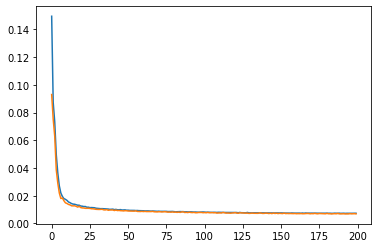

In [5]:
plt.plot(range(len(train_loss_epoch)), train_loss_epoch)
plt.plot(range(len(test_loss_epoch)), test_loss_epoch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.28616097 0.6047878 ]
1.1994427


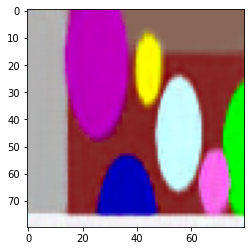

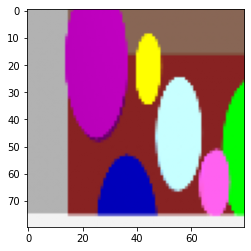

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.35457445 0.83767735]
1.1655596


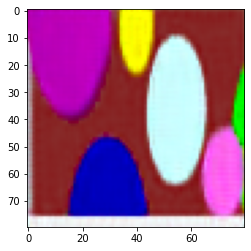

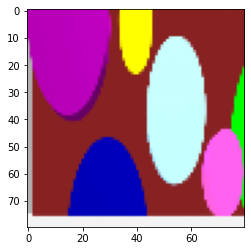

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.39934963 0.12725795]
1.1697805


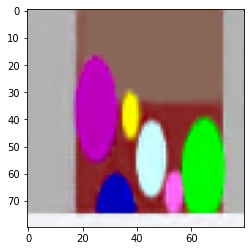

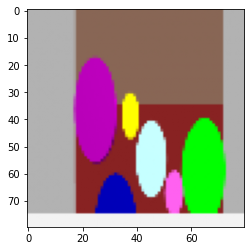

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.50290789 0.36702294]
1.1330754


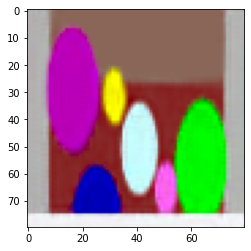

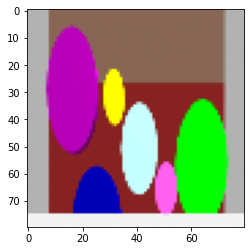

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.74623226 0.00437527]
1.1177675


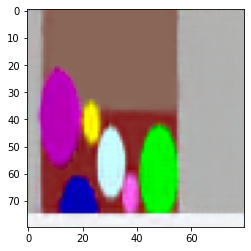

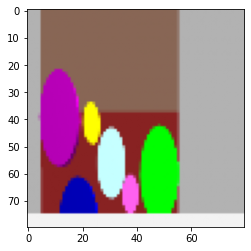

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.91545244 0.68029252]
1.1939945


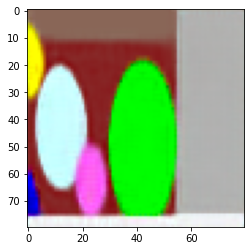

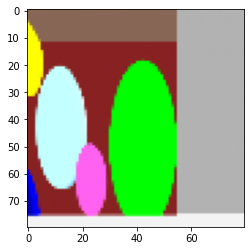

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.03195547 0.44221514]
1.1504681


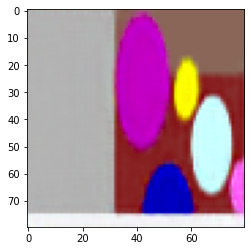

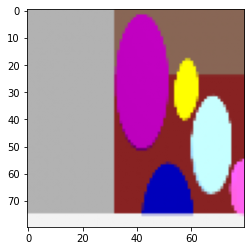

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.25989619 0.688043  ]
1.1316197


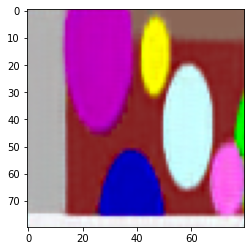

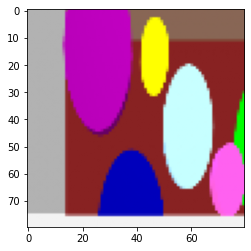

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.83759615 0.21401338]
1.1738033


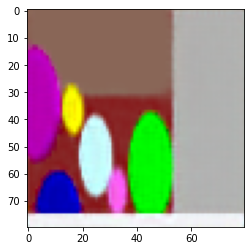

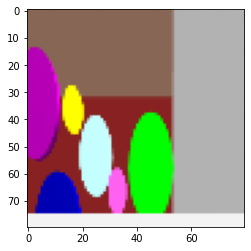

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.79882434 0.97162323]
1.2058947


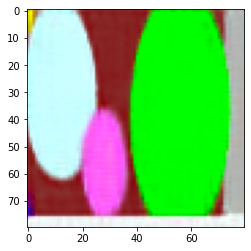

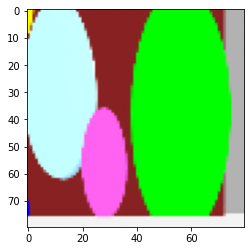

In [6]:
net.eval()
for i in random.sample(range(len(test_pose)), 10):
    print(test_pose[i])
    pred = net(torch.tensor(test_pose[i]).unsqueeze(0).unsqueeze(1).float().cuda()).cpu().detach().numpy().squeeze().transpose(1,2,0)
    print(np.max(pred))
    plt.imshow(pred)
    plt.show()
    plt.imshow(test_img[i].transpose(1,2,0))
    plt.show()